## Insights from results
- Increasing the training samples did not improve the score that much (Re-run with small sample just to check though)
- train: 166159 -> comp_metric at ~ 27 
- train: 536 -> comp_metric at ~ 43.7 (rmse_x: 37.69673776033537 rmse_y: 21.840938110932335 rmse_f: 0.696238586518948)
- For MLP, RMSE was better when trained with 536 samples, at about ~22.4 train loss (with 166159, it was ~ 62 train loss) -> is a prrof that 536 is just too small to be a sample
- Comp metric was way too bad for every model -> lowest was LGBM of ~27 (LB is ~4)
- LGBM has lower score than RF -> Sign of Overfit
- MLP had the worst score with lots of data, and best with small data
- The generated data is just rubbish

In [42]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [43]:
SEED = 42

In [44]:
dir_path = "../input/indoor1stdatafull/"
# dir_path = "../input/indoorpkl/"
train_file_name = dir_path + "indoor_train.pkl"
test_file_name = dir_path + "indoor_test.pkl"

# Try loading it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [45]:
print(len(df_train))
print(len(df_test))
display(df_train.head())
display(df_test.head())

166159
10132


,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1.0,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,0.0,1.560913e+12,-0.210693,-0.304062,9.943115,NaN,1.560913e+12,-0.012902,0.008711,-0.427844,NaN,1.560913e+12,-21.720000,17.76,-36.120000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90.0,NaN,1.560913e+12,186.0,186.0,186.0,530.0,87,10312,2,6746,9039,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1.0,B1,1.560913e+12,21.157534,30.024122,1.560913e+12,9886.0,1.560913e+12,-0.718262,-0.418991,10.347733,NaN,1.560913e+12,-0.006788,0.039279,-0.327645,NaN,1.560913e+12,-19.260000,18.90,-30.179998,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-84.0,NaN,1.560913e+12,9895.0,9895.0,9895.0,9998.0,87,10312,2,6746,9039,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,10.195710,21.657787,1.560913e+12,0.0,1.560913e+12,0.043091,0.275330,9.428360,NaN,1.560913e+12,0.000129,0.000146,-0.757510,NaN,1.560913e+12,-24.180000,-5.16,-26.640000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-87.0,NaN,1.560913e+12,192.0,192.0,192.0,502.0,87,10311,2,6746,9039,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,5292.0,1.560913e+12,-0.541092,1.374268,10.240006,NaN,1.560913e+12,0.078497,-0.037847,-0.717117,NaN,1.560913e+12,-23.820000,-6.90,-26.880000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-76.0,NaN,1.560913e+12,5284.0,5284.0,5284.0,5531.0,87,10311,2,6746,9039,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
2,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,21.089481,19.001072,1.560913e+12,13045.0,1.560913e+12,-0.131683,0.172379,10.309433,NaN,1.560913e+12,0.017186,-0.002997,-0.696129,NaN,1.560913e+12,-26.699999,1.86,-10.620000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-79.0,NaN,1.560913e+12,13051.0,13051.0,13051.0,13216.0,87,10311,2,6746,9039,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00


,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9.0,NaN,NaN,0.0,9.0,136.0,0.798813,4.300720,7.810059,NaN,136.0,0.247101,0.104201,0.474897,NaN,136.0,30.561829,-1.228333,-38.301086,NaN,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,136.0,136.0,136.0,2340.0,0,6,0,1425,3860,1970-01-01 00:00:00.009,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9017.0,NaN,NaN,0.0,9017.0,9012.0,-1.106979,4.056503,9.795456,NaN,9012.0,0.162119,0.185954,0.561409,NaN,9012.0,29.867554,-6.085205,-26.150513,NaN,9508.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-43.0,NaN,1.578475e+12,9012.0,9012.0,9012.0,9508.0,0,6,0,1425,514,1970-01-01 00:00:09.017,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:30.052000000,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,15326.0,NaN,NaN,0.0,15326.0,15326.0,-0.572464,3.981689,7.082230,NaN,15326.0,0.225070,0.022647,-0.200452,NaN,15326.0,-6.207275,14.727783,-39.649963,NaN,14714.0,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b26914599f6d9ba16b43975394e1eeb9d82f4bab,-41.0,NaN,1.578475e+12,15326.0,15326.0,15326.0,14714.0,0,6,0,1179,2934,1970-01-01 00:00:15.326,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:38.027000064,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,18763.0,NaN,NaN,0.0,18763.0,18755.0,-0.751434,4.546112,10.231201,NaN,18755.0,0.225055,0.044806,-0.119175,NaN,18755.0,-1.350403,9.870911,-41.676330,NaN,19587.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,-41.0,NaN,1.578475e+12,18755.0,18755.0,18755.0,19587.0,0,6,0,1425,3634,1970-01-01 00:00:18.763,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:42.716999936,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,22328.0,NaN,NaN,0.0,22328.0,22326.0,-2.089798,4.224701,12.037628,NaN,22326.0,0.242105,0.053464,-0.008162,NaN,22326.0,-1.350403,5.014038,-30.876160,NaN,22074.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-42.0,NaN,1.578475e+12,22326.0,22326.0,22326.0,22074.0,0,6,0,1425,514,1970-01-01 00:00:22.328,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:34.860999936,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00


In [46]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat - x,2) + np.power(yhat-y,2)) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [47]:
# column settings
drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le"]
categorical_features = ["site_id", "file_id", "wifi_ssid", "wifi_bssid"]
datetime_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                     "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                     "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")
    
# convert to int from datetime64 dtype
for col in datetime_features:
    df_train[col] = df_train[col].astype(int)

# set features and labels
# print(df_train.info())

features = df_train.drop(columns=drop_cols)
target_x = df_train.iloc[:, 5]
target_y = df_train.iloc[:, 6]
target_f = df_train.iloc[:, 2]

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

(132927, 42)
(33232, 42)
(132927,)
(33232,)
(132927, 42)
(132927,)
(33232, 42)
(33232,)
(132927, 42)
(33232, 42)
(132927,)
(33232,)
(132927, 42)
(132927,)
(33232, 42)
(33232,)
(132927, 42)
(33232, 42)
(132927,)
(33232,)
(132927, 42)
(132927,)
(33232, 42)
(33232,)


In [49]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 50000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44574
[LightGBM] [Info] Number of data points in the train set: 132927, number of used features: 38
[LightGBM] [Info] Start training from score 98.521784
[1]	valid_0's rmse: 60.7316
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 58.576
[3]	valid_0's rmse: 56.9242
[4]	valid_0's rmse: 54.3239
[5]	valid_0's rmse: 52.7801
[6]	valid_0's rmse: 51.2264
[7]	valid_0's rmse: 48.9902
[8]	valid_0's rmse: 47.386
[9]	valid_0's rmse: 46.0799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 45.2829
[11]	valid_0's rmse: 44.0429
[12]	valid_0's rmse: 43.3776
[13]	valid_0's rmse: 42.2212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's rmse: 41.9431
[15]	valid_0's rmse: 41.1426
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's rmse: 30.6487
[133]	valid_0's rmse: 30.6264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's rmse: 30.6093
[135]	valid_0's rmse: 30.5774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's rmse: 30.5568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's rmse: 30.5383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's rmse: 30.517
[139]	valid_0's rmse: 30.495
[140]	valid_0's rmse: 30.4699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's rmse: 30.4542
[142]	valid_0's rmse: 30.4319
[143]	valid_0's rmse: 30.3634
[144]	valid_0's rmse: 30.3236
[145]	valid_0's rmse: 30.2924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's rmse: 30.28
[147]	valid_0's rmse: 30.2659

[287]	valid_0's rmse: 28.4414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's rmse: 28.4371
[289]	valid_0's rmse: 28.4313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's rmse: 28.4265
[291]	valid_0's rmse: 28.4142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's rmse: 28.407
[293]	valid_0's rmse: 28.3985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's rmse: 28.3935
[295]	valid_0's rmse: 28.3896
[296]	valid_0's rmse: 28.3775
[297]	valid_0's rmse: 28.3675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	valid_0's rmse: 28.3617
[299]	valid_0's rmse: 28.3408
[300]	valid_0's rmse: 28.3327
[301]	valid_0's rmse: 28.322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's rmse: 28.3114
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[470]	valid_0's rmse: 27.2368
[471]	valid_0's rmse: 27.2344
[472]	valid_0's rmse: 27.2327
[473]	valid_0's rmse: 27.2299
[474]	valid_0's rmse: 27.214
[475]	valid_0's rmse: 27.2112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's rmse: 27.2083
[477]	valid_0's rmse: 27.2038
[478]	valid_0's rmse: 27.1999
[479]	valid_0's rmse: 27.1957
[480]	valid_0's rmse: 27.1798
[481]	valid_0's rmse: 27.175
[482]	valid_0's rmse: 27.1669
[483]	valid_0's rmse: 27.1621
[484]	valid_0's rmse: 27.1606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's rmse: 27.1573
[486]	valid_0's rmse: 27.1482
[487]	valid_0's rmse: 27.1381
[488]	valid_0's rmse: 27.1314
[489]	valid_0's rmse: 27.1239
[490]	valid_0's rmse: 27.1151
[491]	valid_0's rmse: 27.1121
[492]	valid_0's rmse: 27.1085
[493]	valid_0's rmse: 27.0955
[494]	valid_0's rmse: 27.094
[495]	valid_0's rmse: 27.0915
[496]	valid_0's rmse: 27.0782
[497]	valid_0's rmse: 27.074
[498]	valid_0'

[667]	valid_0's rmse: 26.2424
[668]	valid_0's rmse: 26.2283
[669]	valid_0's rmse: 26.2178
[670]	valid_0's rmse: 26.2049
[671]	valid_0's rmse: 26.2017
[672]	valid_0's rmse: 26.2008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's rmse: 26.198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's rmse: 26.1968
[675]	valid_0's rmse: 26.1934
[676]	valid_0's rmse: 26.1906
[677]	valid_0's rmse: 26.1839
[678]	valid_0's rmse: 26.1779
[679]	valid_0's rmse: 26.1739
[680]	valid_0's rmse: 26.1718
[681]	valid_0's rmse: 26.1706
[682]	valid_0's rmse: 26.1665
[683]	valid_0's rmse: 26.1653
[684]	valid_0's rmse: 26.1644
[685]	valid_0's rmse: 26.1598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's rmse: 26.1567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's rmse: 26.1547
[688]	valid_0's rmse: 26.1498
[689]	valid_0's rmse: 26.148
[690]	valid_

[905]	valid_0's rmse: 25.4423
[906]	valid_0's rmse: 25.4426
[907]	valid_0's rmse: 25.4322
[908]	valid_0's rmse: 25.4316
[909]	valid_0's rmse: 25.425
[910]	valid_0's rmse: 25.4227
[911]	valid_0's rmse: 25.4214
[912]	valid_0's rmse: 25.4214
[913]	valid_0's rmse: 25.4172
[914]	valid_0's rmse: 25.4106
[915]	valid_0's rmse: 25.4078
[916]	valid_0's rmse: 25.4059
[917]	valid_0's rmse: 25.4032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	valid_0's rmse: 25.4009
[919]	valid_0's rmse: 25.398
[920]	valid_0's rmse: 25.3925
[921]	valid_0's rmse: 25.3915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	valid_0's rmse: 25.389
[923]	valid_0's rmse: 25.3872
[924]	valid_0's rmse: 25.3861
[925]	valid_0's rmse: 25.3855
[926]	valid_0's rmse: 25.385
[927]	valid_0's rmse: 25.38
[928]	valid_0's rmse: 25.3762
[929]	valid_0's rmse: 25.3752
[930]	valid_0's rmse: 25.3754
[931]	valid_0's rmse: 25.3743
[932]	valid_0's rmse: 25.3752
[933]	valid_0's 

[1119]	valid_0's rmse: 24.9338
[1120]	valid_0's rmse: 24.9331
[1121]	valid_0's rmse: 24.9278
[1122]	valid_0's rmse: 24.924
[1123]	valid_0's rmse: 24.9237
[1124]	valid_0's rmse: 24.9225
[1125]	valid_0's rmse: 24.9183
[1126]	valid_0's rmse: 24.9169
[1127]	valid_0's rmse: 24.9133
[1128]	valid_0's rmse: 24.9127
[1129]	valid_0's rmse: 24.9101
[1130]	valid_0's rmse: 24.9066
[1131]	valid_0's rmse: 24.9056
[1132]	valid_0's rmse: 24.9033
[1133]	valid_0's rmse: 24.9021
[1134]	valid_0's rmse: 24.8991
[1135]	valid_0's rmse: 24.8976
[1136]	valid_0's rmse: 24.8946
[1137]	valid_0's rmse: 24.8931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1138]	valid_0's rmse: 24.8917
[1139]	valid_0's rmse: 24.8916
[1140]	valid_0's rmse: 24.8893
[1141]	valid_0's rmse: 24.8901
[1142]	valid_0's rmse: 24.8888
[1143]	valid_0's rmse: 24.8876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 24.8867
[1145]	valid_0's rmse: 24.8843
[1146]	valid_0

[1321]	valid_0's rmse: 24.5702
[1322]	valid_0's rmse: 24.5694
[1323]	valid_0's rmse: 24.5683
[1324]	valid_0's rmse: 24.5668
[1325]	valid_0's rmse: 24.5668
[1326]	valid_0's rmse: 24.5607
[1327]	valid_0's rmse: 24.5592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's rmse: 24.5585
[1329]	valid_0's rmse: 24.5545
[1330]	valid_0's rmse: 24.5522
[1331]	valid_0's rmse: 24.5489
[1332]	valid_0's rmse: 24.5459
[1333]	valid_0's rmse: 24.5449
[1334]	valid_0's rmse: 24.5433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1335]	valid_0's rmse: 24.5423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 24.5416
[1337]	valid_0's rmse: 24.5405
[1338]	valid_0's rmse: 24.5402
[1339]	valid_0's rmse: 24.5376
[1340]	valid_0's rmse: 24.5356
[1341]	valid_0's rmse: 24.5345
[1342]	valid_0's rmse: 24.5308
[1343]	valid_0's rmse: 24.5299
[1344]	valid_0's rmse: 24.5287
[1345]	valid_0's rmse: 24.5269


[1533]	valid_0's rmse: 24.2651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1534]	valid_0's rmse: 24.2642
[1535]	valid_0's rmse: 24.2632
[1536]	valid_0's rmse: 24.2596
[1537]	valid_0's rmse: 24.2544
[1538]	valid_0's rmse: 24.2535
[1539]	valid_0's rmse: 24.252
[1540]	valid_0's rmse: 24.2518
[1541]	valid_0's rmse: 24.2507
[1542]	valid_0's rmse: 24.2512
[1543]	valid_0's rmse: 24.2491
[1544]	valid_0's rmse: 24.2482
[1545]	valid_0's rmse: 24.2451
[1546]	valid_0's rmse: 24.2419
[1547]	valid_0's rmse: 24.242
[1548]	valid_0's rmse: 24.2398
[1549]	valid_0's rmse: 24.2363
[1550]	valid_0's rmse: 24.2352
[1551]	valid_0's rmse: 24.2339
[1552]	valid_0's rmse: 24.2329
[1553]	valid_0's rmse: 24.2325
[1554]	valid_0's rmse: 24.2227
[1555]	valid_0's rmse: 24.2222
[1556]	valid_0's rmse: 24.2211
[1557]	valid_0's rmse: 24.2214
[1558]	valid_0's rmse: 24.2176
[1559]	valid_0's rmse: 24.2125
[1560]	valid_0's rmse: 24.2121
[1561]	valid_0's rmse: 24.2104
[1562]	valid_0's rmse: 24.21

[1747]	valid_0's rmse: 23.9476
[1748]	valid_0's rmse: 23.9461
[1749]	valid_0's rmse: 23.9407
[1750]	valid_0's rmse: 23.9408
[1751]	valid_0's rmse: 23.9398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's rmse: 23.939
[1753]	valid_0's rmse: 23.9389
[1754]	valid_0's rmse: 23.9395
[1755]	valid_0's rmse: 23.9341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1756]	valid_0's rmse: 23.9322
[1757]	valid_0's rmse: 23.9268
[1758]	valid_0's rmse: 23.9253
[1759]	valid_0's rmse: 23.9206
[1760]	valid_0's rmse: 23.9118
[1761]	valid_0's rmse: 23.9105
[1762]	valid_0's rmse: 23.9106
[1763]	valid_0's rmse: 23.9106
[1764]	valid_0's rmse: 23.9074
[1765]	valid_0's rmse: 23.9073
[1766]	valid_0's rmse: 23.906
[1767]	valid_0's rmse: 23.9047
[1768]	valid_0's rmse: 23.9035
[1769]	valid_0's rmse: 23.9027
[1770]	valid_0's rmse: 23.9028
[1771]	valid_0's rmse: 23.9026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

[1961]	valid_0's rmse: 23.71
[1962]	valid_0's rmse: 23.7094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's rmse: 23.7087
[1964]	valid_0's rmse: 23.7086
[1965]	valid_0's rmse: 23.7091
[1966]	valid_0's rmse: 23.7086
[1967]	valid_0's rmse: 23.7055
[1968]	valid_0's rmse: 23.7032
[1969]	valid_0's rmse: 23.6981
[1970]	valid_0's rmse: 23.6973
[1971]	valid_0's rmse: 23.6971
[1972]	valid_0's rmse: 23.695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1973]	valid_0's rmse: 23.6942
[1974]	valid_0's rmse: 23.6916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1975]	valid_0's rmse: 23.691
[1976]	valid_0's rmse: 23.69
[1977]	valid_0's rmse: 23.6863
[1978]	valid_0's rmse: 23.6832
[1979]	valid_0's rmse: 23.6813
[1980]	valid_0's rmse: 23.682
[1981]	valid_0's rmse: 23.6793
[1982]	valid_0's rmse: 23.679
[1983]	valid_0's rmse: 23.6784
[1984]	valid_0's rmse: 23.6775
[1985]	valid_0's rmse: 23.6758
[1986]	v

[2176]	valid_0's rmse: 23.4903
[2177]	valid_0's rmse: 23.489
[2178]	valid_0's rmse: 23.4893
[2179]	valid_0's rmse: 23.4893
[2180]	valid_0's rmse: 23.4884
[2181]	valid_0's rmse: 23.4886
[2182]	valid_0's rmse: 23.4889
[2183]	valid_0's rmse: 23.489
[2184]	valid_0's rmse: 23.4897
[2185]	valid_0's rmse: 23.49
[2186]	valid_0's rmse: 23.4904
[2187]	valid_0's rmse: 23.4908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2188]	valid_0's rmse: 23.4898
[2189]	valid_0's rmse: 23.4894
[2190]	valid_0's rmse: 23.4889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2191]	valid_0's rmse: 23.4884
[2192]	valid_0's rmse: 23.4857
[2193]	valid_0's rmse: 23.4853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2194]	valid_0's rmse: 23.4853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2195]	valid_0's rmse: 23.4848
[2196]	valid_0's rmse: 23.4842
[2197]	valid_0's rmse: 23.4833
[2198]	valid_0's rmse:

[2400]	valid_0's rmse: 23.2985
[2401]	valid_0's rmse: 23.2977
[2402]	valid_0's rmse: 23.2978
[2403]	valid_0's rmse: 23.2976
[2404]	valid_0's rmse: 23.297
[2405]	valid_0's rmse: 23.2965
[2406]	valid_0's rmse: 23.2951
[2407]	valid_0's rmse: 23.2932
[2408]	valid_0's rmse: 23.2937
[2409]	valid_0's rmse: 23.2941
[2410]	valid_0's rmse: 23.2937
[2411]	valid_0's rmse: 23.2936
[2412]	valid_0's rmse: 23.2921
[2413]	valid_0's rmse: 23.2896
[2414]	valid_0's rmse: 23.2905
[2415]	valid_0's rmse: 23.2904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's rmse: 23.2907
[2417]	valid_0's rmse: 23.2902
[2418]	valid_0's rmse: 23.2902
[2419]	valid_0's rmse: 23.2905
[2420]	valid_0's rmse: 23.2906
[2421]	valid_0's rmse: 23.2888
[2422]	valid_0's rmse: 23.2892
[2423]	valid_0's rmse: 23.2887
[2424]	valid_0's rmse: 23.2881
[2425]	valid_0's rmse: 23.2834
[2426]	valid_0's rmse: 23.2808
[2427]	valid_0's rmse: 23.2784
[2428]	valid_0's rmse: 23.2792
[2429]	valid_0's rmse: 23.2

[2626]	valid_0's rmse: 23.1211
[2627]	valid_0's rmse: 23.1216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2628]	valid_0's rmse: 23.1215
[2629]	valid_0's rmse: 23.1199
[2630]	valid_0's rmse: 23.1198
[2631]	valid_0's rmse: 23.1185
[2632]	valid_0's rmse: 23.1182
[2633]	valid_0's rmse: 23.1187
[2634]	valid_0's rmse: 23.1196
[2635]	valid_0's rmse: 23.1189
[2636]	valid_0's rmse: 23.1163
[2637]	valid_0's rmse: 23.116
[2638]	valid_0's rmse: 23.1159
[2639]	valid_0's rmse: 23.1153
[2640]	valid_0's rmse: 23.1151
[2641]	valid_0's rmse: 23.1112
[2642]	valid_0's rmse: 23.1116
[2643]	valid_0's rmse: 23.1101
[2644]	valid_0's rmse: 23.1099
[2645]	valid_0's rmse: 23.1093
[2646]	valid_0's rmse: 23.1096
[2647]	valid_0's rmse: 23.111
[2648]	valid_0's rmse: 23.1112
[2649]	valid_0's rmse: 23.1109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2650]	valid_0's rmse: 23.1105
[2651]	valid_0's rmse: 23.1103
[2652]	valid_0's rmse: 23.1086
[2653]	valid_0'

[2838]	valid_0's rmse: 22.9731
[2839]	valid_0's rmse: 22.9728
[2840]	valid_0's rmse: 22.9716
[2841]	valid_0's rmse: 22.971
[2842]	valid_0's rmse: 22.9704
[2843]	valid_0's rmse: 22.9697
[2844]	valid_0's rmse: 22.9702
[2845]	valid_0's rmse: 22.9701
[2846]	valid_0's rmse: 22.97
[2847]	valid_0's rmse: 22.9695
[2848]	valid_0's rmse: 22.9685
[2849]	valid_0's rmse: 22.9674
[2850]	valid_0's rmse: 22.966
[2851]	valid_0's rmse: 22.9653
[2852]	valid_0's rmse: 22.9637
[2853]	valid_0's rmse: 22.961
[2854]	valid_0's rmse: 22.9574
[2855]	valid_0's rmse: 22.9568
[2856]	valid_0's rmse: 22.9566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2857]	valid_0's rmse: 22.9557
[2858]	valid_0's rmse: 22.9549
[2859]	valid_0's rmse: 22.9546
[2860]	valid_0's rmse: 22.9546
[2861]	valid_0's rmse: 22.9546
[2862]	valid_0's rmse: 22.9516
[2863]	valid_0's rmse: 22.9505
[2864]	valid_0's rmse: 22.9464
[2865]	valid_0's rmse: 22.947
[2866]	valid_0's rmse: 22.9466
[2867]	valid_0's rmse: 22.9455
[

[3060]	valid_0's rmse: 22.8389
[3061]	valid_0's rmse: 22.8374
[3062]	valid_0's rmse: 22.8362
[3063]	valid_0's rmse: 22.8363
[3064]	valid_0's rmse: 22.837
[3065]	valid_0's rmse: 22.8355
[3066]	valid_0's rmse: 22.8355
[3067]	valid_0's rmse: 22.8355
[3068]	valid_0's rmse: 22.8353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3069]	valid_0's rmse: 22.8351
[3070]	valid_0's rmse: 22.8351
[3071]	valid_0's rmse: 22.8345
[3072]	valid_0's rmse: 22.8311
[3073]	valid_0's rmse: 22.8308
[3074]	valid_0's rmse: 22.8312
[3075]	valid_0's rmse: 22.8309
[3076]	valid_0's rmse: 22.8312
[3077]	valid_0's rmse: 22.8308
[3078]	valid_0's rmse: 22.8301
[3079]	valid_0's rmse: 22.8293
[3080]	valid_0's rmse: 22.8286
[3081]	valid_0's rmse: 22.8276
[3082]	valid_0's rmse: 22.8271
[3083]	valid_0's rmse: 22.8253
[3084]	valid_0's rmse: 22.8221
[3085]	valid_0's rmse: 22.8222
[3086]	valid_0's rmse: 22.8223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3087]	valid_0

[3279]	valid_0's rmse: 22.7161
[3280]	valid_0's rmse: 22.7156
[3281]	valid_0's rmse: 22.7161
[3282]	valid_0's rmse: 22.7163
[3283]	valid_0's rmse: 22.7168
[3284]	valid_0's rmse: 22.7175
[3285]	valid_0's rmse: 22.719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3286]	valid_0's rmse: 22.7184
[3287]	valid_0's rmse: 22.7195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3288]	valid_0's rmse: 22.7191
[3289]	valid_0's rmse: 22.7179
[3290]	valid_0's rmse: 22.7158
[3291]	valid_0's rmse: 22.7161
[3292]	valid_0's rmse: 22.7137
[3293]	valid_0's rmse: 22.7137
[3294]	valid_0's rmse: 22.7134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3295]	valid_0's rmse: 22.7132
[3296]	valid_0's rmse: 22.713
[3297]	valid_0's rmse: 22.7123
[3298]	valid_0's rmse: 22.7116
[3299]	valid_0's rmse: 22.7109
[3300]	valid_0's rmse: 22.711
[3301]	valid_0's rmse: 22.7106
[3302]	valid_0's rmse: 22.7101
[3303]	valid_0's rmse: 22.7099
[33

[3503]	valid_0's rmse: 22.5977
[3504]	valid_0's rmse: 22.597
[3505]	valid_0's rmse: 22.5963
[3506]	valid_0's rmse: 22.5969
[3507]	valid_0's rmse: 22.5974
[3508]	valid_0's rmse: 22.5972
[3509]	valid_0's rmse: 22.5947
[3510]	valid_0's rmse: 22.5946
[3511]	valid_0's rmse: 22.5946
[3512]	valid_0's rmse: 22.5947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3513]	valid_0's rmse: 22.5945
[3514]	valid_0's rmse: 22.594
[3515]	valid_0's rmse: 22.594
[3516]	valid_0's rmse: 22.5938
[3517]	valid_0's rmse: 22.5933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3518]	valid_0's rmse: 22.5933
[3519]	valid_0's rmse: 22.5905
[3520]	valid_0's rmse: 22.5889
[3521]	valid_0's rmse: 22.5856
[3522]	valid_0's rmse: 22.5855
[3523]	valid_0's rmse: 22.5837
[3524]	valid_0's rmse: 22.5834
[3525]	valid_0's rmse: 22.5836
[3526]	valid_0's rmse: 22.5826
[3527]	valid_0's rmse: 22.5826
[3528]	valid_0's rmse: 22.5829
[3529]	valid_0's rmse: 22.5808
[LightGBM] [Warn

[3725]	valid_0's rmse: 22.5006
[3726]	valid_0's rmse: 22.5006
[3727]	valid_0's rmse: 22.4986
[3728]	valid_0's rmse: 22.4988
[3729]	valid_0's rmse: 22.4983
[3730]	valid_0's rmse: 22.4984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3731]	valid_0's rmse: 22.4986
[3732]	valid_0's rmse: 22.4979
[3733]	valid_0's rmse: 22.4974
[3734]	valid_0's rmse: 22.4974
[3735]	valid_0's rmse: 22.4977
[3736]	valid_0's rmse: 22.4978
[3737]	valid_0's rmse: 22.4978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3738]	valid_0's rmse: 22.4978
[3739]	valid_0's rmse: 22.4988
[3740]	valid_0's rmse: 22.4982
[3741]	valid_0's rmse: 22.4979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3742]	valid_0's rmse: 22.4979
[3743]	valid_0's rmse: 22.4973
[3744]	valid_0's rmse: 22.4974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3745]	valid_0's rmse: 22.4968
[3746]	valid_0's rmse: 22.4969
[3747]	valid_0's r

[3952]	valid_0's rmse: 22.3829
[3953]	valid_0's rmse: 22.3833
[3954]	valid_0's rmse: 22.3834
[3955]	valid_0's rmse: 22.3829
[3956]	valid_0's rmse: 22.3821
[3957]	valid_0's rmse: 22.3816
[3958]	valid_0's rmse: 22.3817
[3959]	valid_0's rmse: 22.3815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3960]	valid_0's rmse: 22.3811
[3961]	valid_0's rmse: 22.3787
[3962]	valid_0's rmse: 22.3785
[3963]	valid_0's rmse: 22.3796
[3964]	valid_0's rmse: 22.3806
[3965]	valid_0's rmse: 22.3794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3966]	valid_0's rmse: 22.379
[3967]	valid_0's rmse: 22.379
[3968]	valid_0's rmse: 22.3783
[3969]	valid_0's rmse: 22.3781
[3970]	valid_0's rmse: 22.3773
[3971]	valid_0's rmse: 22.3765
[3972]	valid_0's rmse: 22.3765
[3973]	valid_0's rmse: 22.3754
[3974]	valid_0's rmse: 22.3754
[3975]	valid_0's rmse: 22.3742
[3976]	valid_0's rmse: 22.3742
[3977]	valid_0's rmse: 22.3741
[3978]	valid_0's rmse: 22.3742
[3979]	valid_0'

[4170]	valid_0's rmse: 22.3116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4171]	valid_0's rmse: 22.3111
[4172]	valid_0's rmse: 22.3104
[4173]	valid_0's rmse: 22.3089
[4174]	valid_0's rmse: 22.3081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4175]	valid_0's rmse: 22.3082
[4176]	valid_0's rmse: 22.3083
[4177]	valid_0's rmse: 22.3085
[4178]	valid_0's rmse: 22.3088
[4179]	valid_0's rmse: 22.3074
[4180]	valid_0's rmse: 22.3066
[4181]	valid_0's rmse: 22.3062
[4182]	valid_0's rmse: 22.3062
[4183]	valid_0's rmse: 22.3058
[4184]	valid_0's rmse: 22.3051
[4185]	valid_0's rmse: 22.3046
[4186]	valid_0's rmse: 22.3054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4187]	valid_0's rmse: 22.3052
[4188]	valid_0's rmse: 22.3048
[4189]	valid_0's rmse: 22.304
[4190]	valid_0's rmse: 22.3041
[4191]	valid_0's rmse: 22.3038
[4192]	valid_0's rmse: 22.3039
[4193]	valid_0's rmse: 22.3032
[4194]	valid_0's rmse: 22.303
[4

[4378]	valid_0's rmse: 22.244
[4379]	valid_0's rmse: 22.2442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4380]	valid_0's rmse: 22.2441
[4381]	valid_0's rmse: 22.2438
[4382]	valid_0's rmse: 22.2435
[4383]	valid_0's rmse: 22.2434
[4384]	valid_0's rmse: 22.2424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4385]	valid_0's rmse: 22.2423
[4386]	valid_0's rmse: 22.2418
[4387]	valid_0's rmse: 22.2417
[4388]	valid_0's rmse: 22.241
[4389]	valid_0's rmse: 22.2401
[4390]	valid_0's rmse: 22.2397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4391]	valid_0's rmse: 22.2389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4392]	valid_0's rmse: 22.238
[4393]	valid_0's rmse: 22.2363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4394]	valid_0's rmse: 22.2367
[4395]	valid_0's rmse: 22.2364
[4396]	valid_0's rmse: 22.2368
[4397]	valid_0's rmse: 22.2361
[4398]	v

[4580]	valid_0's rmse: 22.1677
[4581]	valid_0's rmse: 22.1655
[4582]	valid_0's rmse: 22.1658
[4583]	valid_0's rmse: 22.166
[4584]	valid_0's rmse: 22.1662
[4585]	valid_0's rmse: 22.1663
[4586]	valid_0's rmse: 22.1652
[4587]	valid_0's rmse: 22.1647
[4588]	valid_0's rmse: 22.1633
[4589]	valid_0's rmse: 22.1632
[4590]	valid_0's rmse: 22.1635
[4591]	valid_0's rmse: 22.1642
[4592]	valid_0's rmse: 22.1627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4593]	valid_0's rmse: 22.1622
[4594]	valid_0's rmse: 22.1621
[4595]	valid_0's rmse: 22.1616
[4596]	valid_0's rmse: 22.1619
[4597]	valid_0's rmse: 22.1616
[4598]	valid_0's rmse: 22.1621
[4599]	valid_0's rmse: 22.1619
[4600]	valid_0's rmse: 22.161
[4601]	valid_0's rmse: 22.1614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4602]	valid_0's rmse: 22.1609
[4603]	valid_0's rmse: 22.1609
[4604]	valid_0's rmse: 22.1611
[4605]	valid_0's rmse: 22.1619
[4606]	valid_0's rmse: 22.1615
[4607]	valid_0'

[4781]	valid_0's rmse: 22.1196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4782]	valid_0's rmse: 22.1196
[4783]	valid_0's rmse: 22.1191
[4784]	valid_0's rmse: 22.12
[4785]	valid_0's rmse: 22.1198
[4786]	valid_0's rmse: 22.1199
[4787]	valid_0's rmse: 22.1187
[4788]	valid_0's rmse: 22.117
[4789]	valid_0's rmse: 22.1168
[4790]	valid_0's rmse: 22.1162
[4791]	valid_0's rmse: 22.1165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4792]	valid_0's rmse: 22.1166
[4793]	valid_0's rmse: 22.1166
[4794]	valid_0's rmse: 22.1172
[4795]	valid_0's rmse: 22.1176
[4796]	valid_0's rmse: 22.1175
[4797]	valid_0's rmse: 22.1162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4798]	valid_0's rmse: 22.1156
[4799]	valid_0's rmse: 22.1155
[4800]	valid_0's rmse: 22.1161
[4801]	valid_0's rmse: 22.1159
[4802]	valid_0's rmse: 22.1165
[4803]	valid_0's rmse: 22.1162
[4804]	valid_0's rmse: 22.116
[LightGBM] [Warning] No further spl

[4967]	valid_0's rmse: 22.0719
[4968]	valid_0's rmse: 22.0718
[4969]	valid_0's rmse: 22.0713
[4970]	valid_0's rmse: 22.0711
[4971]	valid_0's rmse: 22.0713
[4972]	valid_0's rmse: 22.0708
[4973]	valid_0's rmse: 22.0704
[4974]	valid_0's rmse: 22.0697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4975]	valid_0's rmse: 22.0694
[4976]	valid_0's rmse: 22.0692
[4977]	valid_0's rmse: 22.0688
[4978]	valid_0's rmse: 22.0693
[4979]	valid_0's rmse: 22.0682
[4980]	valid_0's rmse: 22.0682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4981]	valid_0's rmse: 22.0679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4982]	valid_0's rmse: 22.0678
[4983]	valid_0's rmse: 22.0683
[4984]	valid_0's rmse: 22.0683
[4985]	valid_0's rmse: 22.0678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4986]	valid_0's rmse: 22.0678
[4987]	valid_0's rmse: 22.0685
[LightGBM] [Warning] No further splits with posit

[5163]	valid_0's rmse: 22.0325
[5164]	valid_0's rmse: 22.0326
[5165]	valid_0's rmse: 22.0333
[5166]	valid_0's rmse: 22.0333
[5167]	valid_0's rmse: 22.0322
[5168]	valid_0's rmse: 22.0319
[5169]	valid_0's rmse: 22.0308
[5170]	valid_0's rmse: 22.0306
[5171]	valid_0's rmse: 22.0298
[5172]	valid_0's rmse: 22.0291
[5173]	valid_0's rmse: 22.0287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5174]	valid_0's rmse: 22.0285
[5175]	valid_0's rmse: 22.028
[5176]	valid_0's rmse: 22.0281
[5177]	valid_0's rmse: 22.0276
[5178]	valid_0's rmse: 22.0274
[5179]	valid_0's rmse: 22.0269
[5180]	valid_0's rmse: 22.0272
[5181]	valid_0's rmse: 22.027
[5182]	valid_0's rmse: 22.0266
[5183]	valid_0's rmse: 22.026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5184]	valid_0's rmse: 22.0258
[5185]	valid_0's rmse: 22.0248
[5186]	valid_0's rmse: 22.025
[5187]	valid_0's rmse: 22.0247
[5188]	valid_0's rmse: 22.0247
[5189]	valid_0's rmse: 22.0241
[5190]	valid_0's 

[59]	valid_0's rmse: 32.1622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's rmse: 32.1109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's rmse: 32.0661
[62]	valid_0's rmse: 31.9622
[63]	valid_0's rmse: 31.8741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's rmse: 31.8232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's rmse: 31.7673
[66]	valid_0's rmse: 31.6946
[67]	valid_0's rmse: 31.6274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's rmse: 31.5878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 31.5422
[70]	valid_0's rmse: 31.4874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's rmse: 31.4378
[72]	valid_0's rmse: 31.3978
[73]	valid_0's rmse: 31.3633
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 27.9472
[202]	valid_0's rmse: 27.9407
[203]	valid_0's rmse: 27.9307
[204]	valid_0's rmse: 27.9171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's rmse: 27.9072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's rmse: 27.8906
[207]	valid_0's rmse: 27.8859
[208]	valid_0's rmse: 27.8744
[209]	valid_0's rmse: 27.8582
[210]	valid_0's rmse: 27.8527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's rmse: 27.8437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's rmse: 27.8317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's rmse: 27.8183
[214]	valid_0's rmse: 27.7984
[215]	valid_0's rmse: 27.7786
[216]	valid_0's rmse: 27.7633
[217]	valid_0's rmse: 27.7333
[218]	valid_0's rmse: 27.7256
[219]	vali

[370]	valid_0's rmse: 26.2244
[371]	valid_0's rmse: 26.2189
[372]	valid_0's rmse: 26.2113
[373]	valid_0's rmse: 26.2042
[374]	valid_0's rmse: 26.1979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's rmse: 26.1958
[376]	valid_0's rmse: 26.1904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's rmse: 26.185
[378]	valid_0's rmse: 26.1821
[379]	valid_0's rmse: 26.1798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's rmse: 26.1768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's rmse: 26.1713
[382]	valid_0's rmse: 26.168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's rmse: 26.1631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's rmse: 26.157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's rmse: 26.153

[564]	valid_0's rmse: 25.167
[565]	valid_0's rmse: 25.1673
[566]	valid_0's rmse: 25.1633
[567]	valid_0's rmse: 25.1567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[568]	valid_0's rmse: 25.155
[569]	valid_0's rmse: 25.1518
[570]	valid_0's rmse: 25.1506
[571]	valid_0's rmse: 25.1466
[572]	valid_0's rmse: 25.1443
[573]	valid_0's rmse: 25.1427
[574]	valid_0's rmse: 25.1358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's rmse: 25.1341
[576]	valid_0's rmse: 25.1253
[577]	valid_0's rmse: 25.1236
[578]	valid_0's rmse: 25.1173
[579]	valid_0's rmse: 25.1021
[580]	valid_0's rmse: 25.0964
[581]	valid_0's rmse: 25.0955
[582]	valid_0's rmse: 25.0944
[583]	valid_0's rmse: 25.0855
[584]	valid_0's rmse: 25.0689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	valid_0's rmse: 25.0672
[586]	valid_0's rmse: 25.0648
[587]	valid_0's rmse: 25.0632
[588]	valid_0's rmse: 25.0622
[589]	valid_0's rmse: 25.06

[784]	valid_0's rmse: 24.3968
[785]	valid_0's rmse: 24.3954
[786]	valid_0's rmse: 24.3923
[787]	valid_0's rmse: 24.3911
[788]	valid_0's rmse: 24.3901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[789]	valid_0's rmse: 24.3882
[790]	valid_0's rmse: 24.3882
[791]	valid_0's rmse: 24.3871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[792]	valid_0's rmse: 24.3838
[793]	valid_0's rmse: 24.3811
[794]	valid_0's rmse: 24.38
[795]	valid_0's rmse: 24.3786
[796]	valid_0's rmse: 24.3782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[797]	valid_0's rmse: 24.3754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[798]	valid_0's rmse: 24.3712
[799]	valid_0's rmse: 24.3685
[800]	valid_0's rmse: 24.3645
[801]	valid_0's rmse: 24.3623
[802]	valid_0's rmse: 24.3608
[803]	valid_0's rmse: 24.3593
[804]	valid_0's rmse: 24.3567
[805]	valid_0's rmse: 24.3544
[806]	valid_0's rmse: 24.3551
[807]	valid_

[1018]	valid_0's rmse: 23.8382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1019]	valid_0's rmse: 23.8335
[1020]	valid_0's rmse: 23.83
[1021]	valid_0's rmse: 23.8292
[1022]	valid_0's rmse: 23.8285
[1023]	valid_0's rmse: 23.8279
[1024]	valid_0's rmse: 23.8273
[1025]	valid_0's rmse: 23.828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1026]	valid_0's rmse: 23.8267
[1027]	valid_0's rmse: 23.8251
[1028]	valid_0's rmse: 23.8265
[1029]	valid_0's rmse: 23.8257
[1030]	valid_0's rmse: 23.8253
[1031]	valid_0's rmse: 23.8251
[1032]	valid_0's rmse: 23.8258
[1033]	valid_0's rmse: 23.8217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 23.8206
[1035]	valid_0's rmse: 23.8213
[1036]	valid_0's rmse: 23.8174
[1037]	valid_0's rmse: 23.8164
[1038]	valid_0's rmse: 23.8133
[1039]	valid_0's rmse: 23.8127
[1040]	valid_0's rmse: 23.8107
[1041]	valid_0's rmse: 23.8082
[1042]	valid_0's rmse: 23.8049
[10

[1234]	valid_0's rmse: 23.4099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1235]	valid_0's rmse: 23.4101
[1236]	valid_0's rmse: 23.4079
[1237]	valid_0's rmse: 23.4068
[1238]	valid_0's rmse: 23.4002
[1239]	valid_0's rmse: 23.3979
[1240]	valid_0's rmse: 23.396
[1241]	valid_0's rmse: 23.3947
[1242]	valid_0's rmse: 23.3893
[1243]	valid_0's rmse: 23.3851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1244]	valid_0's rmse: 23.384
[1245]	valid_0's rmse: 23.386
[1246]	valid_0's rmse: 23.3867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1247]	valid_0's rmse: 23.3865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1248]	valid_0's rmse: 23.3863
[1249]	valid_0's rmse: 23.3851
[1250]	valid_0's rmse: 23.3806
[1251]	valid_0's rmse: 23.3805
[1252]	valid_0's rmse: 23.3786
[1253]	valid_0's rmse: 23.3782
[1254]	valid_0's rmse: 23.3772
[1255]	valid_0's rmse: 23.3769
[1256]	valid_0's rmse

[1443]	valid_0's rmse: 23.1027
[1444]	valid_0's rmse: 23.1021
[1445]	valid_0's rmse: 23.1022
[1446]	valid_0's rmse: 23.1024
[1447]	valid_0's rmse: 23.1029
[1448]	valid_0's rmse: 23.1022
[1449]	valid_0's rmse: 23.1026
[1450]	valid_0's rmse: 23.0995
[1451]	valid_0's rmse: 23.0981
[1452]	valid_0's rmse: 23.0987
[1453]	valid_0's rmse: 23.0989
[1454]	valid_0's rmse: 23.0977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1455]	valid_0's rmse: 23.097
[1456]	valid_0's rmse: 23.089
[1457]	valid_0's rmse: 23.0882
[1458]	valid_0's rmse: 23.0897
[1459]	valid_0's rmse: 23.0876
[1460]	valid_0's rmse: 23.0873
[1461]	valid_0's rmse: 23.0824
[1462]	valid_0's rmse: 23.0809
[1463]	valid_0's rmse: 23.0807
[1464]	valid_0's rmse: 23.0807
[1465]	valid_0's rmse: 23.0794
[1466]	valid_0's rmse: 23.0795
[1467]	valid_0's rmse: 23.0785
[1468]	valid_0's rmse: 23.0779
[1469]	valid_0's rmse: 23.069
[1470]	valid_0's rmse: 23.0676
[1471]	valid_0's rmse: 23.0672
[1472]	valid_0's rmse: 23.066

[1677]	valid_0's rmse: 22.8288
[1678]	valid_0's rmse: 22.8287
[1679]	valid_0's rmse: 22.8287
[1680]	valid_0's rmse: 22.8287
[1681]	valid_0's rmse: 22.8285
[1682]	valid_0's rmse: 22.8265
[1683]	valid_0's rmse: 22.821
[1684]	valid_0's rmse: 22.8211
[1685]	valid_0's rmse: 22.821
[1686]	valid_0's rmse: 22.8204
[1687]	valid_0's rmse: 22.8185
[1688]	valid_0's rmse: 22.8141
[1689]	valid_0's rmse: 22.8123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1690]	valid_0's rmse: 22.8114
[1691]	valid_0's rmse: 22.8104
[1692]	valid_0's rmse: 22.8072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1693]	valid_0's rmse: 22.8063
[1694]	valid_0's rmse: 22.8039
[1695]	valid_0's rmse: 22.805
[1696]	valid_0's rmse: 22.8041
[1697]	valid_0's rmse: 22.7949
[1698]	valid_0's rmse: 22.7922
[1699]	valid_0's rmse: 22.7924
[1700]	valid_0's rmse: 22.7916
[1701]	valid_0's rmse: 22.7886
[1702]	valid_0's rmse: 22.7853
[1703]	valid_0's rmse: 22.7855
[1704]	valid_0's

[1901]	valid_0's rmse: 22.5525
[1902]	valid_0's rmse: 22.5523
[1903]	valid_0's rmse: 22.5508
[1904]	valid_0's rmse: 22.55
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1905]	valid_0's rmse: 22.5494
[1906]	valid_0's rmse: 22.5502
[1907]	valid_0's rmse: 22.5463
[1908]	valid_0's rmse: 22.5464
[1909]	valid_0's rmse: 22.5458
[1910]	valid_0's rmse: 22.5452
[1911]	valid_0's rmse: 22.5433
[1912]	valid_0's rmse: 22.5419
[1913]	valid_0's rmse: 22.5404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1914]	valid_0's rmse: 22.5386
[1915]	valid_0's rmse: 22.5368
[1916]	valid_0's rmse: 22.5364
[1917]	valid_0's rmse: 22.5358
[1918]	valid_0's rmse: 22.5358
[1919]	valid_0's rmse: 22.5355
[1920]	valid_0's rmse: 22.5337
[1921]	valid_0's rmse: 22.5327
[1922]	valid_0's rmse: 22.5312
[1923]	valid_0's rmse: 22.5295
[1924]	valid_0's rmse: 22.5293
[1925]	valid_0's rmse: 22.5286
[1926]	valid_0's rmse: 22.5273
[1927]	valid_0's rmse: 22.525
[1928]	valid_0's

[2121]	valid_0's rmse: 22.3637
[2122]	valid_0's rmse: 22.3635
[2123]	valid_0's rmse: 22.3631
[2124]	valid_0's rmse: 22.3631
[2125]	valid_0's rmse: 22.3613
[2126]	valid_0's rmse: 22.3609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2127]	valid_0's rmse: 22.3599
[2128]	valid_0's rmse: 22.3589
[2129]	valid_0's rmse: 22.357
[2130]	valid_0's rmse: 22.3555
[2131]	valid_0's rmse: 22.3553
[2132]	valid_0's rmse: 22.3535
[2133]	valid_0's rmse: 22.3534
[2134]	valid_0's rmse: 22.3532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2135]	valid_0's rmse: 22.3525
[2136]	valid_0's rmse: 22.3524
[2137]	valid_0's rmse: 22.3523
[2138]	valid_0's rmse: 22.3526
[2139]	valid_0's rmse: 22.353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2140]	valid_0's rmse: 22.3514
[2141]	valid_0's rmse: 22.3506
[2142]	valid_0's rmse: 22.3497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2143]	valid_0's rms

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 1.6757
[11]	valid_0's rmse: 1.63294
[12]	valid_0's rmse: 1.60217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's rmse: 1.56478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's rmse: 1.55581
[15]	valid_0's rmse: 1.5263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's rmse: 1.51939
[17]	valid_0's rmse: 1.49283
[18]	valid_0's rmse: 1.47064
[19]	valid_0's rmse: 1.44751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 1.43228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's rmse: 1.42287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's rmse: 1.39906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's rmse: 1.38

[110]	valid_0's rmse: 0.953919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's rmse: 0.952607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's rmse: 0.951763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's rmse: 0.950785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's rmse: 0.950275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's rmse: 0.948609
[116]	valid_0's rmse: 0.945118
[117]	valid_0's rmse: 0.939759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's rmse: 0.939024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's rmse: 0.937625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's rmse: 0.93724
[121]	valid_0's rmse: 0.935239
[LightGBM] [Warning] No furth

[216]	valid_0's rmse: 0.805474
[217]	valid_0's rmse: 0.802989
[218]	valid_0's rmse: 0.802553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's rmse: 0.801814
[220]	valid_0's rmse: 0.800786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's rmse: 0.800615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's rmse: 0.799517
[223]	valid_0's rmse: 0.798362
[224]	valid_0's rmse: 0.797493
[225]	valid_0's rmse: 0.795197
[226]	valid_0's rmse: 0.794803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[227]	valid_0's rmse: 0.794235
[228]	valid_0's rmse: 0.792822
[229]	valid_0's rmse: 0.790602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's rmse: 0.79027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's rmse: 0.790039
[LightGBM] [Warning] No further splits with positive ga

[341]	valid_0's rmse: 0.718319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's rmse: 0.718175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's rmse: 0.717873
[344]	valid_0's rmse: 0.71702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's rmse: 0.716481
[346]	valid_0's rmse: 0.715096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's rmse: 0.714714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's rmse: 0.714385
[349]	valid_0's rmse: 0.713894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's rmse: 0.713254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's rmse: 0.713175
[352]	valid_0's rmse: 0.712283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's rmse: 0.71193

[461]	valid_0's rmse: 0.673831
[462]	valid_0's rmse: 0.673176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	valid_0's rmse: 0.673043
[464]	valid_0's rmse: 0.672368
[465]	valid_0's rmse: 0.672188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[466]	valid_0's rmse: 0.672112
[467]	valid_0's rmse: 0.671222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's rmse: 0.671166
[469]	valid_0's rmse: 0.670564
[470]	valid_0's rmse: 0.670161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's rmse: 0.669954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's rmse: 0.669905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 0.669861
[474]	valid_0's rmse: 0.66899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's rmse: 0.66874
[LightGBM] [

[598]	valid_0's rmse: 0.63021
[599]	valid_0's rmse: 0.629636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 0.629397
[601]	valid_0's rmse: 0.629057
[602]	valid_0's rmse: 0.628706
[603]	valid_0's rmse: 0.628621
[604]	valid_0's rmse: 0.628109
[605]	valid_0's rmse: 0.627635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 0.627566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 0.627454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 0.627392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 0.627228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 0.627189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's rmse: 0.627165
[LightGBM] [Warning] No further splits wit

[736]	valid_0's rmse: 0.59877
[737]	valid_0's rmse: 0.598586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	valid_0's rmse: 0.598445
[739]	valid_0's rmse: 0.598183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 0.598171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 0.598104
[742]	valid_0's rmse: 0.597605
[743]	valid_0's rmse: 0.597304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 0.597276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 0.597162
[746]	valid_0's rmse: 0.596763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 0.596743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's rmse: 0.596749
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[871]	valid_0's rmse: 0.578179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's rmse: 0.578095
[873]	valid_0's rmse: 0.577948
[874]	valid_0's rmse: 0.577648
[875]	valid_0's rmse: 0.577393
[876]	valid_0's rmse: 0.577119
[877]	valid_0's rmse: 0.577084
[878]	valid_0's rmse: 0.577034
[879]	valid_0's rmse: 0.576502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 0.576463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 0.576421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 0.576395
[883]	valid_0's rmse: 0.576194
[884]	valid_0's rmse: 0.575912
[885]	valid_0's rmse: 0.575632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 0.575593
[887]	valid_0's rmse: 0.575428
[888]	valid_0's rmse: 0.574927
[889]	valid_0's rmse: 0.574357
[LightGBM] [Warning] No further spli

[998]	valid_0's rmse: 0.561045
[999]	valid_0's rmse: 0.560862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.560826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1001]	valid_0's rmse: 0.560775
[1002]	valid_0's rmse: 0.560535
[1003]	valid_0's rmse: 0.560392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1004]	valid_0's rmse: 0.560351
[1005]	valid_0's rmse: 0.560123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's rmse: 0.560102
[1007]	valid_0's rmse: 0.559643
[1008]	valid_0's rmse: 0.559469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's rmse: 0.559448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 0.559412
[1011]	valid_0's rmse: 0.559319
[1012]	valid_0's rmse: 0.559227
[1013]	valid_0's rmse: 0.559163
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1131]	valid_0's rmse: 0.546152
[1132]	valid_0's rmse: 0.545898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1133]	valid_0's rmse: 0.54587
[1134]	valid_0's rmse: 0.545743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1135]	valid_0's rmse: 0.545691
[1136]	valid_0's rmse: 0.545583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	valid_0's rmse: 0.545549
[1138]	valid_0's rmse: 0.545539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1139]	valid_0's rmse: 0.545529
[1140]	valid_0's rmse: 0.545485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 0.545436
[1142]	valid_0's rmse: 0.545327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 0.545161
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1265]	valid_0's rmse: 0.534255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1266]	valid_0's rmse: 0.534137
[1267]	valid_0's rmse: 0.53415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1268]	valid_0's rmse: 0.53412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1269]	valid_0's rmse: 0.534097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1270]	valid_0's rmse: 0.5341
[1271]	valid_0's rmse: 0.534021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 0.533987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 0.533956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 0.533939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	va

[1394]	valid_0's rmse: 0.525903
[1395]	valid_0's rmse: 0.525827
[1396]	valid_0's rmse: 0.525761
[1397]	valid_0's rmse: 0.525703
[1398]	valid_0's rmse: 0.525685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1399]	valid_0's rmse: 0.525674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	valid_0's rmse: 0.52566
[1401]	valid_0's rmse: 0.525544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1402]	valid_0's rmse: 0.525505
[1403]	valid_0's rmse: 0.525317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's rmse: 0.525306
[1405]	valid_0's rmse: 0.525253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's rmse: 0.525214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's rmse: 0.525196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's rmse: 0.525

[1513]	valid_0's rmse: 0.518236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1514]	valid_0's rmse: 0.518206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1515]	valid_0's rmse: 0.518189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1516]	valid_0's rmse: 0.518187
[1517]	valid_0's rmse: 0.518157
[1518]	valid_0's rmse: 0.518015
[1519]	valid_0's rmse: 0.517971
[1520]	valid_0's rmse: 0.517932
[1521]	valid_0's rmse: 0.517809
[1522]	valid_0's rmse: 0.517801
[1523]	valid_0's rmse: 0.517678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's rmse: 0.517665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's rmse: 0.517645
[1526]	valid_0's rmse: 0.517546
[1527]	valid_0's rmse: 0.517482
[1528]	valid_0's rmse: 0.517412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1529]	valid_0's rmse: 0.517415
[Light

[1644]	valid_0's rmse: 0.512143
[1645]	valid_0's rmse: 0.512127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1646]	valid_0's rmse: 0.51208
[1647]	valid_0's rmse: 0.512047
[1648]	valid_0's rmse: 0.511953
[1649]	valid_0's rmse: 0.511887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's rmse: 0.511861
[1651]	valid_0's rmse: 0.511601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	valid_0's rmse: 0.511579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	valid_0's rmse: 0.511563
[1654]	valid_0's rmse: 0.511502
[1655]	valid_0's rmse: 0.511449
[1656]	valid_0's rmse: 0.511374
[1657]	valid_0's rmse: 0.511293
[1658]	valid_0's rmse: 0.511228
[1659]	valid_0's rmse: 0.511089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's rmse: 0.511079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	

[1783]	valid_0's rmse: 0.505647
[1784]	valid_0's rmse: 0.505636
[1785]	valid_0's rmse: 0.505604
[1786]	valid_0's rmse: 0.505541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1787]	valid_0's rmse: 0.505529
[1788]	valid_0's rmse: 0.505519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1789]	valid_0's rmse: 0.505418
[1790]	valid_0's rmse: 0.505306
[1791]	valid_0's rmse: 0.505265
[1792]	valid_0's rmse: 0.505206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's rmse: 0.505192
[1794]	valid_0's rmse: 0.505148
[1795]	valid_0's rmse: 0.505107
[1796]	valid_0's rmse: 0.505087
[1797]	valid_0's rmse: 0.504933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1798]	valid_0's rmse: 0.50491
[1799]	valid_0's rmse: 0.504873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1800]	valid_0's rmse: 0.504859
[LightGBM] [Warning] No further splits with positi

[1927]	valid_0's rmse: 0.49935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1928]	valid_0's rmse: 0.499351
[1929]	valid_0's rmse: 0.499219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1930]	valid_0's rmse: 0.49921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1931]	valid_0's rmse: 0.499172
[1932]	valid_0's rmse: 0.499159
[1933]	valid_0's rmse: 0.499146
[1934]	valid_0's rmse: 0.499121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's rmse: 0.499128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's rmse: 0.499122
[1937]	valid_0's rmse: 0.499028
[1938]	valid_0's rmse: 0.49896
[1939]	valid_0's rmse: 0.498963
[1940]	valid_0's rmse: 0.498918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's rmse: 0.4989
[1942]	valid_0's rmse: 0.498834
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2060]	valid_0's rmse: 0.495041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2061]	valid_0's rmse: 0.495032
[2062]	valid_0's rmse: 0.494923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2063]	valid_0's rmse: 0.494908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2064]	valid_0's rmse: 0.494897
[2065]	valid_0's rmse: 0.494847
[2066]	valid_0's rmse: 0.494765
[2067]	valid_0's rmse: 0.49472
[2068]	valid_0's rmse: 0.494633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2069]	valid_0's rmse: 0.494628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2070]	valid_0's rmse: 0.494625
[2071]	valid_0's rmse: 0.494585
[2072]	valid_0's rmse: 0.494534
[2073]	valid_0's rmse: 0.494498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2074]	valid_0's rmse: 0.494

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2198]	valid_0's rmse: 0.490136
[2199]	valid_0's rmse: 0.490066
[2200]	valid_0's rmse: 0.490054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2201]	valid_0's rmse: 0.490029
[2202]	valid_0's rmse: 0.49003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2203]	valid_0's rmse: 0.490011
[2204]	valid_0's rmse: 0.489863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2205]	valid_0's rmse: 0.489869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2206]	valid_0's rmse: 0.489895
[2207]	valid_0's rmse: 0.489821
[2208]	valid_0's rmse: 0.489767
[2209]	valid_0's rmse: 0.489731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2210]	valid_0's rmse: 0.489714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2211]	valid_0's rmse: 0.489724
[2212]	valid_0's rmse: 0.489

[2340]	valid_0's rmse: 0.485621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2341]	valid_0's rmse: 0.485593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2342]	valid_0's rmse: 0.485555
[2343]	valid_0's rmse: 0.485477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2344]	valid_0's rmse: 0.485458
[2345]	valid_0's rmse: 0.485421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2346]	valid_0's rmse: 0.485426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2347]	valid_0's rmse: 0.485394
[2348]	valid_0's rmse: 0.485386
[2349]	valid_0's rmse: 0.485313
[2350]	valid_0's rmse: 0.485289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2351]	valid_0's rmse: 0.485289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2352]	valid_0's rmse: 0.485297
[2353]	valid_0's rmse: 0.485258
[2354]	valid_0's rmse: 0.48

[2464]	valid_0's rmse: 0.482587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2465]	valid_0's rmse: 0.482583
[2466]	valid_0's rmse: 0.482555
[2467]	valid_0's rmse: 0.482509
[2468]	valid_0's rmse: 0.482456
[2469]	valid_0's rmse: 0.482434
[2470]	valid_0's rmse: 0.482426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2471]	valid_0's rmse: 0.482412
[2472]	valid_0's rmse: 0.482389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2473]	valid_0's rmse: 0.482386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2474]	valid_0's rmse: 0.482382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2475]	valid_0's rmse: 0.48236
[2476]	valid_0's rmse: 0.482337
[2477]	valid_0's rmse: 0.482243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2478]	valid_0's rmse: 0.482235
[2479]	valid_0's rmse: 0.482191
[2480]	valid_0's rmse: 0.482172
[2481]	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2613]	valid_0's rmse: 0.478528
[2614]	valid_0's rmse: 0.478521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2615]	valid_0's rmse: 0.478512
[2616]	valid_0's rmse: 0.478487
[2617]	valid_0's rmse: 0.478486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2618]	valid_0's rmse: 0.478484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2619]	valid_0's rmse: 0.478478
[2620]	valid_0's rmse: 0.478458
[2621]	valid_0's rmse: 0.478412
[2622]	valid_0's rmse: 0.478364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2623]	valid_0's rmse: 0.478341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2624]	valid_0's rmse: 0.47833
[2625]	valid_0's rmse: 0.478313
[2626]	valid_0's rmse: 0.478281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2627]	valid_0's rmse: 0.478

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2744]	valid_0's rmse: 0.475723
[2745]	valid_0's rmse: 0.475743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2746]	valid_0's rmse: 0.475722
[2747]	valid_0's rmse: 0.47572
[2748]	valid_0's rmse: 0.475695
[2749]	valid_0's rmse: 0.475647
[2750]	valid_0's rmse: 0.475591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2751]	valid_0's rmse: 0.475588
[2752]	valid_0's rmse: 0.47558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2753]	valid_0's rmse: 0.475579
[2754]	valid_0's rmse: 0.475513
[2755]	valid_0's rmse: 0.475463
[2756]	valid_0's rmse: 0.475422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2757]	valid_0's rmse: 0.475407
[2758]	valid_0's rmse: 0.47536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2759]	valid_0's rmse: 0.475359
[2760]	valid_0's rmse: 0.47531
[LightGBM]

[2872]	valid_0's rmse: 0.47332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2873]	valid_0's rmse: 0.473316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2874]	valid_0's rmse: 0.473326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2875]	valid_0's rmse: 0.473318
[2876]	valid_0's rmse: 0.473244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2877]	valid_0's rmse: 0.473242
[2878]	valid_0's rmse: 0.473148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2879]	valid_0's rmse: 0.47316
[2880]	valid_0's rmse: 0.473124
[2881]	valid_0's rmse: 0.473123
[2882]	valid_0's rmse: 0.473118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2883]	valid_0's rmse: 0.473098
[2884]	valid_0's rmse: 0.473041
[2885]	valid_0's rmse: 0.472994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2886]	valid_0's rmse: 0.4729

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3008]	valid_0's rmse: 0.470442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3009]	valid_0's rmse: 0.470439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3010]	valid_0's rmse: 0.470436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3011]	valid_0's rmse: 0.470421
[3012]	valid_0's rmse: 0.470368
[3013]	valid_0's rmse: 0.470339
[3014]	valid_0's rmse: 0.470293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3015]	valid_0's rmse: 0.470265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3016]	valid_0's rmse: 0.470256
[3017]	valid_0's rmse: 0.470239
[3018]	valid_0's rmse: 0.470204
[3019]	valid_0's rmse: 0.470185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3020]	valid_0's rmse: 0.470179
[3021]	valid_0's rmse: 0.470186
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3147]	valid_0's rmse: 0.46788
[3148]	valid_0's rmse: 0.467882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3149]	valid_0's rmse: 0.467873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3150]	valid_0's rmse: 0.46787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3151]	valid_0's rmse: 0.467858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3152]	valid_0's rmse: 0.467851
[3153]	valid_0's rmse: 0.467776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3154]	valid_0's rmse: 0.467768
[3155]	valid_0's rmse: 0.467699
[3156]	valid_0's rmse: 0.467685
[3157]	valid_0's rmse: 0.467669
[3158]	valid_0's rmse: 0.46768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3159]	valid_0's rmse: 0.467665
[LightGBM] [Warning] No further splits with positive gain, bes

[3293]	valid_0's rmse: 0.465144
[3294]	valid_0's rmse: 0.465142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3295]	valid_0's rmse: 0.465112
[3296]	valid_0's rmse: 0.465111
[3297]	valid_0's rmse: 0.465076
[3298]	valid_0's rmse: 0.465058
[3299]	valid_0's rmse: 0.465001
[3300]	valid_0's rmse: 0.46498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3301]	valid_0's rmse: 0.464962
[3302]	valid_0's rmse: 0.464958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3303]	valid_0's rmse: 0.464947
[3304]	valid_0's rmse: 0.464944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3305]	valid_0's rmse: 0.464943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3306]	valid_0's rmse: 0.46494
[3307]	valid_0's rmse: 0.464921
[3308]	valid_0's rmse: 0.464916
[3309]	valid_0's rmse: 0.464861
[3310]	valid_0's rmse: 0.46484
[3311]	valid_0's rmse: 0.464808
[3312]	valid_0's rms

[3430]	valid_0's rmse: 0.463087
[3431]	valid_0's rmse: 0.463071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3432]	valid_0's rmse: 0.463069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3433]	valid_0's rmse: 0.463057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3434]	valid_0's rmse: 0.463056
[3435]	valid_0's rmse: 0.463026
[3436]	valid_0's rmse: 0.463019
[3437]	valid_0's rmse: 0.463002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3438]	valid_0's rmse: 0.463008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3439]	valid_0's rmse: 0.462989
[3440]	valid_0's rmse: 0.462986
[3441]	valid_0's rmse: 0.462972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3442]	valid_0's rmse: 0.462966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3443]	valid_0's rmse: 0.462978
[LightGBM] [Warning] No fur

[3575]	valid_0's rmse: 0.461267
[3576]	valid_0's rmse: 0.461244
[3577]	valid_0's rmse: 0.461245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3578]	valid_0's rmse: 0.461264
[3579]	valid_0's rmse: 0.461252
[3580]	valid_0's rmse: 0.461231
[3581]	valid_0's rmse: 0.461223
[3582]	valid_0's rmse: 0.461207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3583]	valid_0's rmse: 0.461205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3584]	valid_0's rmse: 0.461192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3585]	valid_0's rmse: 0.461186
[3586]	valid_0's rmse: 0.461175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3587]	valid_0's rmse: 0.461184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3588]	valid_0's rmse: 0.46118
[3589]	valid_0's rmse: 0.461199
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3711]	valid_0's rmse: 0.45973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3712]	valid_0's rmse: 0.459734
[3713]	valid_0's rmse: 0.459712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3714]	valid_0's rmse: 0.459702
[3715]	valid_0's rmse: 0.459692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3716]	valid_0's rmse: 0.459682
[3717]	valid_0's rmse: 0.459699
[3718]	valid_0's rmse: 0.459641
[3719]	valid_0's rmse: 0.459636
[3720]	valid_0's rmse: 0.45964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3721]	valid_0's rmse: 0.459625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3722]	valid_0's rmse: 0.459625
[3723]	valid_0's rmse: 0.459625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3724]	valid_0's rmse: 0.459614
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3851]	valid_0's rmse: 0.458355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3852]	valid_0's rmse: 0.458336
[3853]	valid_0's rmse: 0.458295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3854]	valid_0's rmse: 0.458302
[3855]	valid_0's rmse: 0.458302
[3856]	valid_0's rmse: 0.458276
[3857]	valid_0's rmse: 0.458274
[3858]	valid_0's rmse: 0.458241
[3859]	valid_0's rmse: 0.458201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3860]	valid_0's rmse: 0.458181
[3861]	valid_0's rmse: 0.458144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3862]	valid_0's rmse: 0.458146
[3863]	valid_0's rmse: 0.458119
[3864]	valid_0's rmse: 0.458084
[3865]	valid_0's rmse: 0.458063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3866]	valid_0's rmse: 0.458041
[3867]	valid_0's rmse: 0.458029
[3868]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3994]	valid_0's rmse: 0.456482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3995]	valid_0's rmse: 0.45648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3996]	valid_0's rmse: 0.456471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3997]	valid_0's rmse: 0.456477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3998]	valid_0's rmse: 0.456465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3999]	valid_0's rmse: 0.456455
[4000]	valid_0's rmse: 0.456414
[4001]	valid_0's rmse: 0.456401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4002]	valid_0's rmse: 0.4564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4003]	valid_0's rmse: 0.456395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4004]	v

[4122]	valid_0's rmse: 0.455165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4123]	valid_0's rmse: 0.455172
[4124]	valid_0's rmse: 0.455165
[4125]	valid_0's rmse: 0.45513
[4126]	valid_0's rmse: 0.455131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4127]	valid_0's rmse: 0.455128
[4128]	valid_0's rmse: 0.455143
[4129]	valid_0's rmse: 0.455105
[4130]	valid_0's rmse: 0.455112
[4131]	valid_0's rmse: 0.455101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4132]	valid_0's rmse: 0.45508
[4133]	valid_0's rmse: 0.455047
[4134]	valid_0's rmse: 0.455038
[4135]	valid_0's rmse: 0.455029
[4136]	valid_0's rmse: 0.455006
[4137]	valid_0's rmse: 0.454966
[4138]	valid_0's rmse: 0.454965
[4139]	valid_0's rmse: 0.454936
[4140]	valid_0's rmse: 0.454916
[4141]	valid_0's rmse: 0.454901
[4142]	valid_0's rmse: 0.454877
[4143]	valid_0's rmse: 0.454868
[4144]	valid_0's rmse: 0.454842
[4145]	valid_0's rmse: 0.454831
[4146]	va

[4278]	valid_0's rmse: 0.45362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4279]	valid_0's rmse: 0.453615
[4280]	valid_0's rmse: 0.453628
[4281]	valid_0's rmse: 0.453623
[4282]	valid_0's rmse: 0.453617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4283]	valid_0's rmse: 0.4536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4284]	valid_0's rmse: 0.453585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4285]	valid_0's rmse: 0.453591
[4286]	valid_0's rmse: 0.453549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4287]	valid_0's rmse: 0.453545
[4288]	valid_0's rmse: 0.453539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4289]	valid_0's rmse: 0.453536
[4290]	valid_0's rmse: 0.4535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4291]	valid_0's rmse: 0.453483
[LightGBM] [Warning] No further 

[4407]	valid_0's rmse: 0.45238
[4408]	valid_0's rmse: 0.452376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4409]	valid_0's rmse: 0.45239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4410]	valid_0's rmse: 0.452398
[4411]	valid_0's rmse: 0.452359
[4412]	valid_0's rmse: 0.452339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4413]	valid_0's rmse: 0.452328
[4414]	valid_0's rmse: 0.452329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4415]	valid_0's rmse: 0.452328
[4416]	valid_0's rmse: 0.452315
[4417]	valid_0's rmse: 0.452293
[4418]	valid_0's rmse: 0.452273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4419]	valid_0's rmse: 0.452267
[4420]	valid_0's rmse: 0.452251
[4421]	valid_0's rmse: 0.45225
[4422]	valid_0's rmse: 0.452241
[4423]	valid_0's rmse: 0.452233
[4424]	valid_0's rmse: 0.452218
[4425]	valid_0's rmse: 0.452218
[4426]	valid_0's rms

[4539]	valid_0's rmse: 0.451346
[4540]	valid_0's rmse: 0.451327
[4541]	valid_0's rmse: 0.451313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4542]	valid_0's rmse: 0.45129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4543]	valid_0's rmse: 0.451283
[4544]	valid_0's rmse: 0.451275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4545]	valid_0's rmse: 0.451283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4546]	valid_0's rmse: 0.451277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4547]	valid_0's rmse: 0.45126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4548]	valid_0's rmse: 0.451249
[4549]	valid_0's rmse: 0.451244
[4550]	valid_0's rmse: 0.451194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4551]	valid_0's rmse: 0.451197
[4552]	valid_0's rmse: 0.451203
[4553]	valid_0's rmse: 0.4511

[4668]	valid_0's rmse: 0.450411
[4669]	valid_0's rmse: 0.450399
[4670]	valid_0's rmse: 0.4504
[4671]	valid_0's rmse: 0.450386
[4672]	valid_0's rmse: 0.450383
[4673]	valid_0's rmse: 0.450344
[4674]	valid_0's rmse: 0.450321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4675]	valid_0's rmse: 0.450316
[4676]	valid_0's rmse: 0.450301
[4677]	valid_0's rmse: 0.450292
[4678]	valid_0's rmse: 0.45028
[4679]	valid_0's rmse: 0.450277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4680]	valid_0's rmse: 0.450279
[4681]	valid_0's rmse: 0.450276
[4682]	valid_0's rmse: 0.450267
[4683]	valid_0's rmse: 0.450261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4684]	valid_0's rmse: 0.45025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4685]	valid_0's rmse: 0.450258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4686]	valid_0's rmse: 0.450235
[LightGBM] [Warning] 

[4812]	valid_0's rmse: 0.449368
[4813]	valid_0's rmse: 0.449332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4814]	valid_0's rmse: 0.449321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4815]	valid_0's rmse: 0.449324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4816]	valid_0's rmse: 0.449329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4817]	valid_0's rmse: 0.449339
[4818]	valid_0's rmse: 0.449316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4819]	valid_0's rmse: 0.449317
[4820]	valid_0's rmse: 0.449318
[4821]	valid_0's rmse: 0.449291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4822]	valid_0's rmse: 0.449302
[4823]	valid_0's rmse: 0.449307
[4824]	valid_0's rmse: 0.449312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4825]	valid_0's rmse: 0.4493
[4826]	valid_0's rmse: 0.4492

[4939]	valid_0's rmse: 0.448434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4940]	valid_0's rmse: 0.44843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4941]	valid_0's rmse: 0.448429
[4942]	valid_0's rmse: 0.448422
[4943]	valid_0's rmse: 0.448421
[4944]	valid_0's rmse: 0.448434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4945]	valid_0's rmse: 0.448423
[4946]	valid_0's rmse: 0.448372
[4947]	valid_0's rmse: 0.448359
[4948]	valid_0's rmse: 0.448358
[4949]	valid_0's rmse: 0.448345
[4950]	valid_0's rmse: 0.448342
[4951]	valid_0's rmse: 0.448342
[4952]	valid_0's rmse: 0.448358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4953]	valid_0's rmse: 0.44835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4954]	valid_0's rmse: 0.448339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4955]	valid_0's rmse: 0.448339
[4956]	v

[5080]	valid_0's rmse: 0.447546
[5081]	valid_0's rmse: 0.447532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5082]	valid_0's rmse: 0.447516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5083]	valid_0's rmse: 0.447511
[5084]	valid_0's rmse: 0.447502
[5085]	valid_0's rmse: 0.447491
[5086]	valid_0's rmse: 0.447484
[5087]	valid_0's rmse: 0.447455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5088]	valid_0's rmse: 0.447459
[5089]	valid_0's rmse: 0.447439
[5090]	valid_0's rmse: 0.447427
[5091]	valid_0's rmse: 0.44743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5092]	valid_0's rmse: 0.447421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5093]	valid_0's rmse: 0.447424
[5094]	valid_0's rmse: 0.447427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5095]	valid_0's rmse: 0.447435
[5096]	valid_0's rmse: 0.447417
[5097]	

[5217]	valid_0's rmse: 0.446778
[5218]	valid_0's rmse: 0.446767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5219]	valid_0's rmse: 0.446745
[5220]	valid_0's rmse: 0.446732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5221]	valid_0's rmse: 0.4467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5222]	valid_0's rmse: 0.446689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5223]	valid_0's rmse: 0.446678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5224]	valid_0's rmse: 0.446682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5225]	valid_0's rmse: 0.44667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5226]	valid_0's rmse: 0.446666
[5227]	valid_0's rmse: 0.44665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5228]	valid_0's rmse: 0.446649
[5229]	valid_0's rms

[5352]	valid_0's rmse: 0.445836
[5353]	valid_0's rmse: 0.445833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5354]	valid_0's rmse: 0.445836
[5355]	valid_0's rmse: 0.445831
[5356]	valid_0's rmse: 0.445831
[5357]	valid_0's rmse: 0.445831
[5358]	valid_0's rmse: 0.445814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5359]	valid_0's rmse: 0.445803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5360]	valid_0's rmse: 0.445808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5361]	valid_0's rmse: 0.445808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5362]	valid_0's rmse: 0.445803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5363]	valid_0's rmse: 0.445798
[5364]	valid_0's rmse: 0.445779
[5365]	valid_0's rmse: 0.445774
[5366]	valid_0's rmse: 0.445748
[5367]	valid_0's rmse: 0.445714
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5486]	valid_0's rmse: 0.444999
[5487]	valid_0's rmse: 0.444983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5488]	valid_0's rmse: 0.444976
[5489]	valid_0's rmse: 0.44497
[5490]	valid_0's rmse: 0.444975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5491]	valid_0's rmse: 0.44498
[5492]	valid_0's rmse: 0.44497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5493]	valid_0's rmse: 0.44496
[5494]	valid_0's rmse: 0.444961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5495]	valid_0's rmse: 0.444945
[5496]	valid_0's rmse: 0.444924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5497]	valid_0's rmse: 0.444921
[5498]	valid_0's rmse: 0.444909
[5499]	valid_0's rmse: 0.444893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's rmse: 0.444888

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5609]	valid_0's rmse: 0.444293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5610]	valid_0's rmse: 0.444295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5611]	valid_0's rmse: 0.444293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5612]	valid_0's rmse: 0.444291
[5613]	valid_0's rmse: 0.444293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5614]	valid_0's rmse: 0.444297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5615]	valid_0's rmse: 0.444294
[5616]	valid_0's rmse: 0.444279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5617]	valid_0's rmse: 0.444282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5618]	valid_0's rmse: 0.4443
[5619]	valid_0's rmse: 0.44429
[5620]	valid_0's rmse: 0.444263
[5621]	valid_0's rm

[5733]	valid_0's rmse: 0.443692
[5734]	valid_0's rmse: 0.443681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5735]	valid_0's rmse: 0.443685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5736]	valid_0's rmse: 0.443678
[5737]	valid_0's rmse: 0.443653
[5738]	valid_0's rmse: 0.443663
[5739]	valid_0's rmse: 0.443654
[5740]	valid_0's rmse: 0.44364
[5741]	valid_0's rmse: 0.443632
[5742]	valid_0's rmse: 0.44361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5743]	valid_0's rmse: 0.443612
[5744]	valid_0's rmse: 0.443603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5745]	valid_0's rmse: 0.443602
[5746]	valid_0's rmse: 0.443585
[5747]	valid_0's rmse: 0.443585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5748]	valid_0's rmse: 0.443588
[5749]	valid_0's rmse: 0.443602
[5750]	valid_0's rmse: 0.443606
[5751]	valid_0's rmse: 0.4436
[5752]	valid_0's rmse

In [50]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'target_train_x', 'target_val_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'target_train_y', 'target_val_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'target_train_f', 'target_val_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
33232
33232


In [51]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 22.010047159553377 rmse_y: 22.22075524114604 rmse_f: 0.4428420130365326


In [52]:
# print(len(d["target_val_x"]))
# print(d["target_val_x"].to_numpy())
# print(type(d["target_val_x"].to_numpy()))

# print(len(d["pred_target_x"]))
# print(d["pred_target_x"])
# print(type(d["pred_target_x"]))

# print(np.power(d["pred_target_x"] - d["target_val_x"].to_numpy(), 2))
# print(np.power(d["pred_target_y"] - d["target_val_y"].to_numpy(), 2))
# a = np.sqrt(np.power(d["pred_target_x"] - d["target_val_x"].to_numpy(), 2) + np.power(d["pred_target_y"] - d["target_val_y"].to_numpy(), 2)) + 15 * np.abs(d["pred_target_f"] - d["target_val_f"].to_numpy())
# print(a.sum() / d["pred_target_x"].shape[0])
# print(d["pred_target_x"].shape[0])

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"], 
                          d["target_val_x"].to_numpy(), d["target_val_y"].to_numpy(), d["target_val_f"])

print("comp metric: ", comp_metric)

comp metric:  28.174243214137434


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

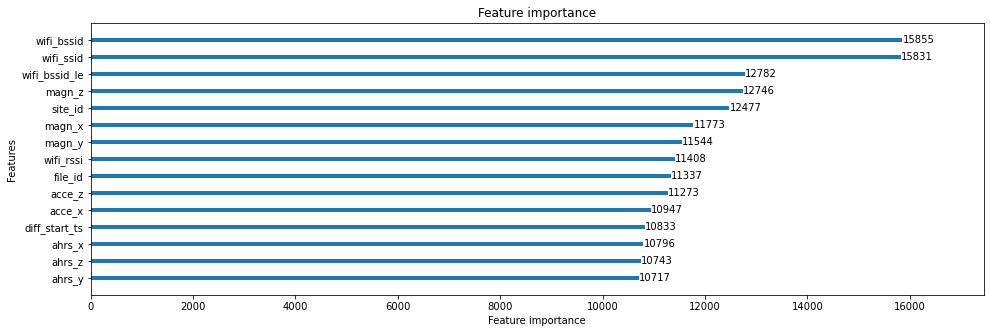

In [55]:
lgb.plot_importance(d["model_x"], max_num_features=15, grid=False, figsize=(16,5))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

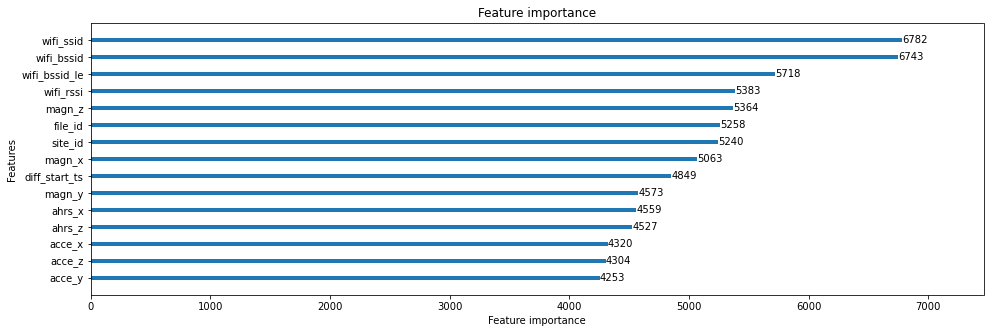

In [56]:
lgb.plot_importance(d["model_y"], max_num_features=15, grid=False, figsize=(16,5))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

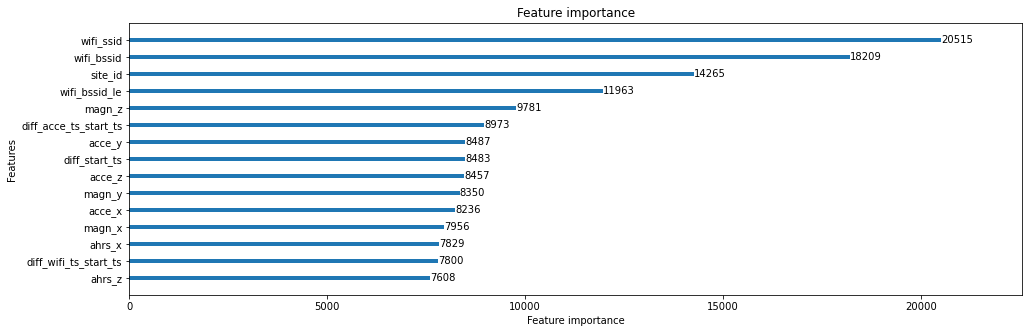

In [58]:
lgb.plot_importance(d["model_f"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
# Prepare new d
d = {}

In [ ]:
# Try RF

# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'rf',
              'n_estimators': 50000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

In [ ]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

In [ ]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

In [ ]:
comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"], 
                          d["target_val_x"].to_numpy(), d["target_val_y"].to_numpy(), d["target_val_f"])

print("comp metric: ", comp_metric)

In [ ]:
# Visualize feature importance
lgb.plot_importance(d["model_x"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_y"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
lgb.plot_importance(d["model_f"], max_num_features=15, grid=False, figsize=(16,5))

In [ ]:
# Try MLP
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [ ]:
# column settings
drop_cols = ["site_id", "file_id", "wifi_ssid", "wifi_bssid", \
             "floor_converted", "floor", "x", "y", "floor_converted_le", \
             "acce_acc", "ahrs_acc", "magn_acc", "wifi_freq"]
datetime_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                     "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                     "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]
    
# convert to int from datetime64 dtype
for col in datetime_features:
    df_train[col] = df_train[col].astype(int)

# set features and labels
# print(df_train.info())

features = df_train.drop(columns=drop_cols)
target_x = df_train.iloc[:, 5]
target_y = df_train.iloc[:, 6]
target_f = df_train.iloc[:, 2]

targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = 42)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
#     d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
#     d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
#     print(d["train_{}".format(tgt)].get_data().shape)
#     print(d["train_{}".format(tgt)].get_label().shape)
#     print(d["val_{}".format(tgt)].get_data().shape)
#     print(d["val_{}".format(tgt)].get_label().shape)

In [ ]:
display(feat_train.head())
display(feat_val.head())
print(len(feat_train))
print(len(feat_val))
print(len(target_train))
print(len(target_val))
print(feat_train.shape)
print(feat_val.shape)

for tgt in targets:
    print(f"feat_train_{tgt}", d["feat_train_{}".format(tgt)].shape)
    print(f"feat_val_{tgt}", d["feat_val_{}".format(tgt)].shape)
    print(f"target_train_{tgt}", d["target_train_{}".format(tgt)].shape)
    print(f"target_val_{tgt}", d["target_val_{}".format(tgt)].shape)

In [ ]:
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_converted_le"]
# features = df_train.drop(columns=drop_cols)


In [ ]:
# Try MLP
# feat_train, feat_val, target_train, target_val

# hyper parameters
input_size = feat_train.shape[1]
print(input_size)
output_size = 1
num_epochs = 5000
learning_rate = 0.1


# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(d["feat_train_y"])
X_test = scaler.transform(d["feat_val_y"])

y_train = np.expand_dims(d["target_train_y"], axis=1)
y_test = np.expand_dims(d["target_val_y"], axis=1)

# linear regression model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear_1 = nn.Linear(input_size, input_size)
        self.linear_2 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear_1(x)
        out = self.linear_2(x)
        return out

model = LinearRegression(input_size, output_size)
print(model)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(X_train, y_train):
#     print("X: ", X_train[0])
#     print("X shape: ", X_train.shape)
#     print("y: ", y_train[0])
#     print("y shape: ", y_train.shape)
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).float()
#     print(inputs.shape)
#     print(targets.shape)

    optimizer.zero_grad()
    outputs = model(inputs)
#     print(outputs.shape)

    loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE so we can compare with lgbm baseline
    loss.backward()
    optimizer.step()

    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).float()
    
    outputs = model(inputs)
    val_loss = torch.sqrt(criterion(outputs, targets)) # Use RMSE not MSE
    
    return val_loss.item()
        
# train the model
loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    loss = train(X_train, y_train)
    val_loss = valid(X_test, y_test)
#     print(loss)
#     print(val_loss)

    if epoch % 200 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, loss, val_loss))

    loss_list.append(loss)
    val_loss_list.append(val_loss)

# plot learning curve
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

In [ ]:
# Run MLP prediction
# Calculate comp_metric score

In [ ]:
# # Load test data
# df_test_pred = df_test.drop(columns=drop_cols)

# # Add "site_path_timestamp" column to df_test
# # convert ts to unix and then convert it to string, and put it in a new column["ts_unix"]
# # join ["site_id", "file_id", "ts_unix"] and put it into a new column ["site_path_timestamp"]
# # or just add it when generating the data -> less steps -> less likely to make a mistake

# test_preds_x = model_x.predict(df_test_pred)
# test_preds_y = model_y.predict(df_test_pred)
# test_preds_f = model_f.predict(df_test_pred)

# # stack the results up with the pairing site_path_timestamp
# # load ssubm
# # test_preds = pd.concat([test_preds_x, test_preds_y, test_preds_f], axis=1)
# test_preds.columns = ssubm.columns
# test_preds.index = df_test_pred["site_path_timestamp"]
# test_preds["floor"] = test_preds["floor"].astype(int)
# predictions.append(test_preds)

In [ ]:
# generate prediction file 
# pd.concat(predictions)
# reindex the prediction df
# convert to csv for submission